In [1]:
from src.data.datasets.glc_po import GLCPODataset
from src.data.predictors.point_bioclim import PointwiseBioclimEuropePredictor
from src.data.predictors.loc import LocationPredictor
import numpy as np
import torch
import pandas as pd
from src.data.predictors.point_bioclim import PointwiseBioclimEuropePredictor
from src.data.predictors.loc import LocationPredictor
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from src.utils.grid_thinning.thinning_strategies import (
    thin_all_species,
    thin_majority_species,
    thin_majority_minority_species
)

In [2]:
from src.data.datasets.glc23_pa import GLC23PADataset

In [3]:
bioclim_path = "/shares/wegner.ics.uzh/glc23_data/bioclim+elev/bioclim_elevation_scaled_europe.npy"
po_dataset_path = "/shares/wegner.ics.uzh/glc23_data/Presences_only_train.csv"

bioclim = PointwiseBioclimEuropePredictor(bioclim_path)
loc = LocationPredictor()

predictors = {"loc_cyclical_europe": loc, 
             "bioclim_pointwise_europe": bioclim}

data_train = GLCPODataset(
   predictors,
   po_dataset_path
)

In [5]:
data_test = GLC23PADataset(
    predictors,
    f"/shares/wegner.ics.uzh/glc23_data/Presence_Absence_surveys/Presences_Absences_train.csv",
)

In [6]:
data_test.data

,patchID,dayOfYear,lat,lon,speciesId
0,55880,126,44.20370,4.74408,"[9562, 2546, 1745, 2871, 9886, 7522, 6755, 762..."
1,55897,126,44.20410,4.74436,"[1602, 7734, 4904, 2871, 8023, 7449, 7760, 540..."
2,55942,126,44.20360,4.74519,"[4355, 7477, 232, 6755, 7622, 3019, 4253, 4615..."
3,56533,126,44.21930,4.75466,"[3281, 7896, 2546, 4965, 4442, 2918, 9170, 897..."
4,56759,126,44.21360,4.75755,"[1344, 6501, 7896, 4965, 7090, 9595, 2502, 950..."
...,...,...,...,...,...
5943,3018845,138,41.87388,9.28662,"[271, 2749, 1514, 644, 5959, 2714, 9679, 8994,..."
5944,3018847,351,41.56691,9.29834,"[271, 4062, 644, 6510, 4190, 8994, 5727, 3800,..."
5945,3018848,346,41.70986,9.31529,"[271, 4062, 4904, 9078, 2749, 615, 2871, 799, ..."
5946,3018853,346,41.67093,9.35871,"[271, 4062, 4904, 799, 6510, 4190, 3649, 8994,..."


In [25]:
# Inverse Class Frequency Weights

species_counts = data_train.data["speciesId"].value_counts()
# Create a weighted random sampler for training, where each sample's weight is the inverse of its species' count
sample_weights_f = [
    1/species_counts[i] for i in\
    data_train.data["speciesId"].values
    ]

In [33]:
# Inverse Cluster Density Weights
data = data_train.data
thin_dist=2

sampled_data, cluster_density = thin_all_species(
    data, 
    thin_dist=2
)

sampled_species_counts = sampled_data["speciesId"].value_counts()

Start thinning of 10038 species...
Thinned speciesId 200/10038 in 0.0279 seconds.
Thinned speciesId 400/10038 in 0.0061 seconds.
Thinned speciesId 600/10038 in 0.0091 seconds.
Thinned speciesId 800/10038 in 0.0275 seconds.
Thinned speciesId 1000/10038 in 0.0081 seconds.
Thinned speciesId 1200/10038 in 0.0052 seconds.
Thinned speciesId 1400/10038 in 0.0053 seconds.
Thinned speciesId 1600/10038 in 0.0068 seconds.
Thinned speciesId 1800/10038 in 0.0074 seconds.
Thinned speciesId 2000/10038 in 0.0052 seconds.
Thinned speciesId 2200/10038 in 0.0055 seconds.
Thinned speciesId 2400/10038 in 0.0054 seconds.
Thinned speciesId 2600/10038 in 0.0078 seconds.
Thinned speciesId 2800/10038 in 0.0057 seconds.
Thinned speciesId 3000/10038 in 0.0056 seconds.
Thinned speciesId 3200/10038 in 0.0271 seconds.
Thinned speciesId 3400/10038 in 0.0054 seconds.
Thinned speciesId 3600/10038 in 0.0057 seconds.
Thinned speciesId 3800/10038 in 0.0053 seconds.
Thinned speciesId 4000/10038 in 0.0054 seconds.
Thinned s

In [34]:
class_weights =  [
    1/(np.sqrt(species_counts[i])*sampled_species_counts[i]) for i in\
    data_train.data["speciesId"].values
]

# the merge is done to ensure that the right cluster
# densities are assigned to the right rows 
data = data.merge(
    cluster_density.rename("cluster_density"),
    left_index=True,
    right_index=True
)
cluster_density_values = data["cluster_density"].values
assert(len(class_weights)==len(cluster_density_values))

sample_weights = class_weights/(cluster_density_values)

In [28]:
x = sample_weights/[species_counts[i] for i in data["speciesId"].values]

In [ ]:
np.sum(sample_weights)

In [ ]:
species_counts = data["speciesId"].value_counts()

In [8]:
/class_counts

Start thinning of 10038 species...
Thinned speciesId 200/10038 in 0.027 seconds.
Thinned speciesId 400/10038 in 0.0088 seconds.
Thinned speciesId 600/10038 in 0.0094 seconds.
Thinned speciesId 800/10038 in 0.0272 seconds.
Thinned speciesId 1000/10038 in 0.0083 seconds.
Thinned speciesId 1200/10038 in 0.0055 seconds.
Thinned speciesId 1400/10038 in 0.0053 seconds.
Thinned speciesId 1600/10038 in 0.0069 seconds.
Thinned speciesId 1800/10038 in 0.0074 seconds.
Thinned speciesId 2000/10038 in 0.0058 seconds.
Thinned speciesId 2200/10038 in 0.0053 seconds.
Thinned speciesId 2400/10038 in 0.0056 seconds.
Thinned speciesId 2600/10038 in 0.0074 seconds.
Thinned speciesId 2800/10038 in 0.0065 seconds.
Thinned speciesId 3000/10038 in 0.0061 seconds.
Thinned speciesId 3200/10038 in 0.0276 seconds.
Thinned speciesId 3400/10038 in 0.0054 seconds.
Thinned speciesId 3600/10038 in 0.0058 seconds.
Thinned speciesId 3800/10038 in 0.0053 seconds.
Thinned speciesId 4000/10038 in 0.0063 seconds.
Thinned sp

In [10]:
len(class_weights)

4908319

In [18]:
np.sum(class_weights)

151813.48290466424

In [15]:
species_counts = data["speciesId"].value_counts()

raw_class_weights =  [
    1/species_counts[i] for i in\
    data_train.data["speciesId"].values
]

In [16]:
np.sum(raw_class_weights)

10038.000000000015

/home/jribas/data/conda/envs/sdm_sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jribas/data/conda/envs/sdm_sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


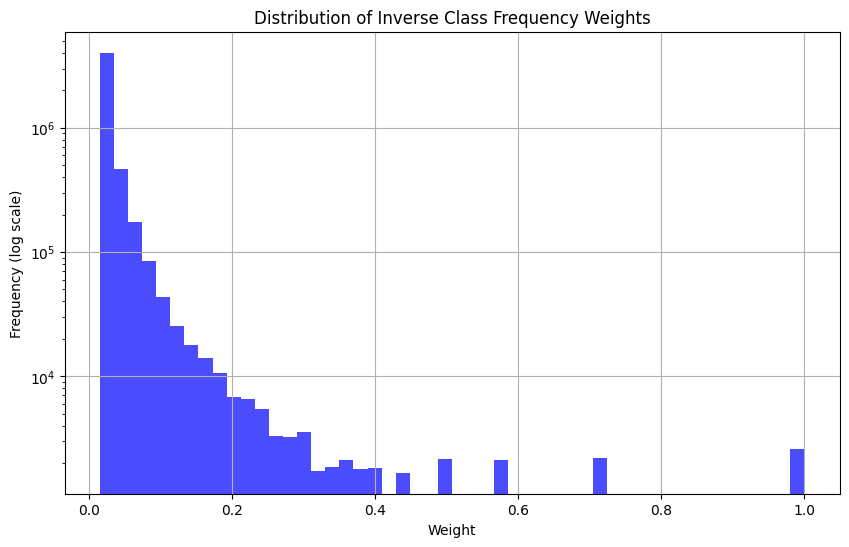

Number of zero weights for Inverse Class Frequency Weights: 0
Mean of zero weights for Inverse Class Frequency Weights: nan


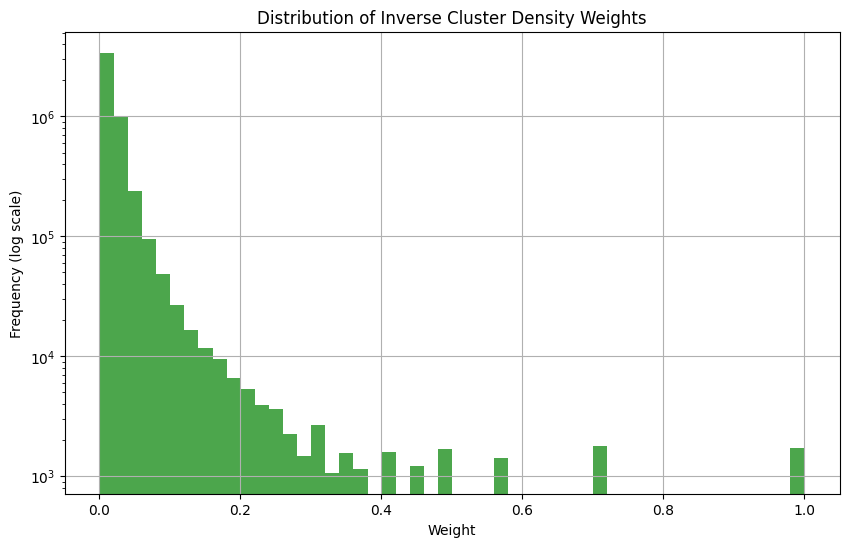

Number of zero weights for Inverse Cluster Density Weights: 0
Mean of zero weights for Inverse Cluster Density Weights: nan


In [30]:
import numpy as np

# Calculate the number of zero weights and their mean
num_zero_weights_f = np.sum(np.array(class_weights) == 0)
mean_zero_weights_f = np.mean(np.array(class_weights)[np.array(class_weights) == 0])

# Plot the distribution of sample weights for Inverse Class Frequency Weights
plt.figure(figsize=(10, 6))
plt.hist(class_weights, bins=50, color='blue', alpha=0.7)
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Distribution of Inverse Class Frequency Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

print(f"Number of zero weights for Inverse Class Frequency Weights: {num_zero_weights_f}")
print(f"Mean of zero weights for Inverse Class Frequency Weights: {mean_zero_weights_f}")

# Calculate the number of zero weights and their mean
num_zero_weights = np.sum(np.array(sample_weights) == 0)
mean_zero_weights = np.mean(np.array(sample_weights)[np.array(sample_weights) == 0])

# Plot the distribution of sample weights for Inverse Cluster Density Weights
plt.figure(figsize=(10, 6))
plt.hist(sample_weights, bins=50, color='green', alpha=0.7)
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title('Distribution of Inverse Cluster Density Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

print(f"Number of zero weights for Inverse Cluster Density Weights: {num_zero_weights}")
print(f"Mean of zero weights for Inverse Cluster Density Weights: {mean_zero_weights}")

In [5]:
# mirar que passa amb aixo!!!

min_weight = min(sample_weights)
scale_factor = 1 / min_weight  # Adjust this factor as needed
sample_weights = [w * scale_factor for w in sample_weights]

NameError: name 'sample_weights' is not defined

In [1]:
dic = {'1000-5000': 1319, '500-1000': 440, '100-500': 1313, '80-100': 184, '60-80': 251, '40-60': 389, '20-40': 813, '0-20': 988} 

In [4]:
import pandas as pd

In [5]:
df = pd.DataFrame()

In [6]:
df["f"] = dic.values()

In [3]:
list(dic.values())

[1319, 440, 1313, 184, 251, 389, 813, 988]

In [7]:
df

,f
0,1319
1,440
2,1313
3,184
4,251
5,389
6,813
7,988


In [8]:
list(dic.values())

[1319, 440, 1313, 184, 251, 389, 813, 988]

<Axes: xlabel='count'>

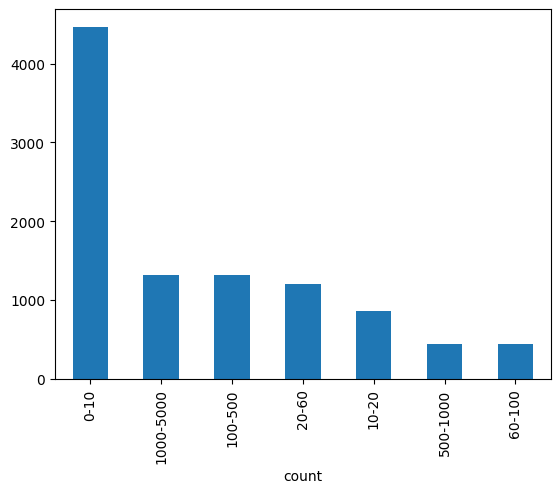

In [6]:
bins = [0, 10, 20, 60, 100, 500, 1000, 5000]
species_counts = data_train.data["speciesId"].value_counts()
grouped_species_ids = pd.cut(species_counts, bins=bins, labels=[f'{start}-{end}' for start, end in zip(bins[:-1], bins[1:])])
grouped_species_ids.value_counts().plot(kind="bar")

In [27]:
grouped_species_ids

speciesId
1995    1000-5000
729     1000-5000
4933    1000-5000
8101    1000-5000
1849    1000-5000
          ...    
2778         0-10
4322         0-10
2895         0-10
2863         0-10
1377         0-10
Name: count, Length: 10038, dtype: category
Categories (7, object): ['0-10' < '10-20' < '20-60' < '60-100' < '100-500' < '500-1000' < '1000-5000']

In [8]:
grouped_species_ids.value_counts()

count
0-10         4469
1000-5000    1319
100-500      1313
20-60        1202
10-20         860
500-1000      440
60-100        435
Name: count, dtype: int64